# [Universal Value Function Approximators](http://jmlr.org/proceedings/papers/v37/schaul15.pdf)

We've seen in class how value function approximation can help generalization across states. But can we push this idea even further ?

Let's imagine we've trained an agent on a gridworld task, and found the optimal value function and thus the optimal policy. Now what if we change the reward position ? If the new goal is not too far from the original one we can probably start from the previous value function and learn quickly the optimal policy. However we if we changed back to the orginal goal, we have to re-learn again. What if we could remember what we've learn from the previous goal, and generalize our value function to a new goal ? That's the idea of Universal Value Function Approximators.

Instead of defining $V_\pi(s)$, we define $V_\pi(s,g)$ (the value function also depends on the goal). This matrix can grow very quickly that's why we need value function approximation.

We first defined a "two-stream" architecture based on matrix factorization, with two-stages:
1. We lay out all the value $V_\pi(s,g)$ in a matrix, we then find a low rank approximation of this matrix $V_\pi(s,g)=\phi_s^T\psi_g$, where $\phi_s$ is $r\times N_s$ and $\psi_g$ is $r\times N_g$ with $N_s$ the state space dimension, $N_g$ the goal space dimension and $r$ a small rank. This decomposition can be obtained by SVD (Singular Value Decomposition).
2. We learn two functions $\phi$ and $\psi$ via separate multivariate regression toward the targets $\phi_s$ and $\psi_g$ from phase 1.

We tried this approach on a gridworld task with 4 rooms. The states and goals were represented by a 1-hot encoding corresponding to their positions in the grid. $\phi$ and $\psi$ are a simple dot product of the state and goal representation with matrix $\theta_\phi$ and $\theta_\psi$. The approach is trained on a random selection of half the goals and tested on the other half for generalization in a supervised learning fashion. The policy we evaluate is a uniform policy over actions.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from lasagne.layers import InputLayer, DenseLayer, get_output, get_all_params
from lasagne import nonlinearities
from lasagne.updates import adam
import theano
import theano.tensor as T
import time

filename = 'data.npy'
rank = 12
lr = 0.005
n_epochs = 10000
batch_size = 20
seed = 1234
np.random.seed(seed)

## Loading dataset of precomputed value function for every state and goal

In [3]:
V = np.load(filename).astype(theano.config.floatX)
idx = np.random.permutation(V.shape[1])
train_idx, test_idx = list(idx[:int(V.shape[1]/2)]), list(idx[int(V.shape[1]/2):])

## Low rank approximation with SVD 

In [4]:
M_train = np.zeros(V.shape, dtype=theano.config.floatX)
M_train[:,train_idx] = V[:,train_idx]

u, s, v = linalg.svds(M_train,k=rank)
phi_s = u
phi_g = np.dot(np.diag(s), v).T

## Defining model

In [5]:
true_state_emb = T.matrix()
state_batch = T.matrix()
state_network = InputLayer(shape=(None, V.shape[0]))
state_network = DenseLayer(state_network, rank, nonlinearity=nonlinearities.linear)
state_emb = get_output(state_network, inputs=state_batch)
loss_state = T.sum((true_state_emb - state_emb)**2, axis=1).mean()
params_state = get_all_params(state_network)
updates_state = adam(loss_state, params_state, learning_rate=lr)

true_goal_emb = T.matrix()
goal_batch = T.matrix()
goal_network = InputLayer(shape=(None, V.shape[1]))
goal_network = DenseLayer(goal_network, rank, nonlinearity=nonlinearities.linear)
goal_emb = get_output(goal_network, inputs=goal_batch)
loss_goal = T.sum((true_goal_emb - goal_emb)**2, axis=1).mean()
params_goal = get_all_params(goal_network)
updates_goal = adam(loss_goal, params_goal, learning_rate=lr)

print "Compiling..."
t = time.time()
train_state_emb = theano.function([true_state_emb, state_batch], [loss_state, state_emb], updates=updates_state)
train_goal_emb = theano.function([true_goal_emb, goal_batch], [loss_goal, goal_emb], updates=updates_goal)
test_state_emb = theano.function([state_batch], state_emb)
test_goal_emb = theano.function([goal_batch], goal_emb)
print '%.2f seconds for compiling.'%(time.time()-t)

Compiling...
3.74 seconds for compiling.


## Training value function approximator

In [6]:
mean_hist_train = []
mean_hist_test = []
for i in range(n_epochs):
    s = np.zeros((batch_size,V.shape[0]), dtype=theano.config.floatX)
    s_idx = np.random.permutation(V.shape[0])[:batch_size]
    s[np.arange(batch_size),s_idx] = 1
    loss_s, state_emb = train_state_emb(phi_s[s_idx], s)

    g = np.zeros((batch_size,V.shape[1]), dtype=theano.config.floatX)
    g_idx = np.random.permutation(train_idx)[:batch_size]
    g[np.arange(batch_size),g_idx] = 1
    loss_g, goal_emb = train_goal_emb(phi_g[g_idx], g)

    s = np.identity(V.shape[0], dtype=theano.config.floatX)
    state_emb = test_state_emb(s)

    g = np.identity(V.shape[1], dtype=theano.config.floatX)
    goal_emb = test_goal_emb(g)
    V_test = state_emb.dot(goal_emb.T)
    mse = (V - V_test)**2
    mean_hist_train.append(mse[:,train_idx].mean())
    mean_hist_test.append(mse[:,test_idx].mean())

## Results and Visualizations

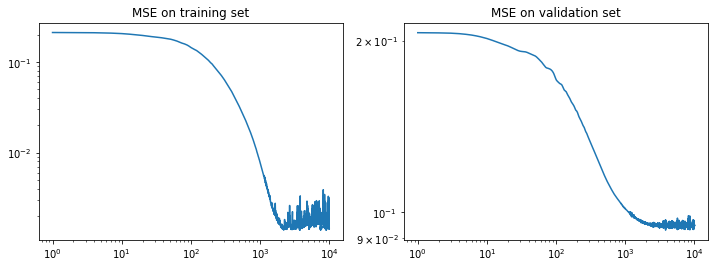

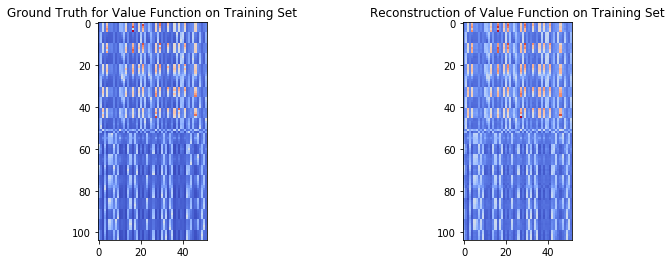

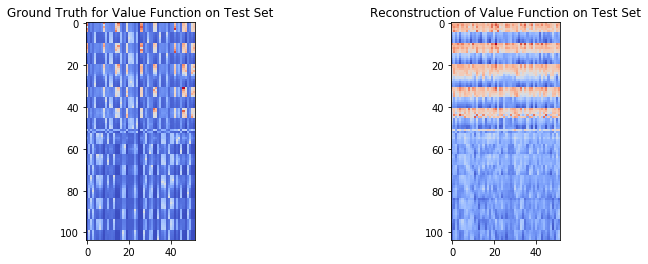

In [7]:
plt.figure(1, figsize=(12,4))
plt.subplot(121)
plt.title('MSE on training set')
plt.loglog(np.arange(len(mean_hist_train)), mean_hist_train)
plt.subplot(122)
plt.title('MSE on validation set')
plt.loglog(np.arange(len(mean_hist_train)), mean_hist_test)

plt.figure(2, figsize=(12,4))
plt.subplot(121)
plt.title('Ground Truth for Value Function on Training Set')
plt.imshow(V[:,train_idx], cmap='coolwarm')
plt.subplot(122)
plt.title('Reconstruction of Value Function on Training Set')
plt.imshow(V_test[:,train_idx], cmap='coolwarm')

plt.figure(3, figsize=(12,4))
plt.subplot(121)
plt.title('Ground Truth for Value Function on Test Set')
plt.imshow(V[:,test_idx], cmap='coolwarm')
plt.subplot(122)
plt.title('Reconstruction of Value Function on Test Set')
plt.imshow(V_test[:,test_idx], cmap='coolwarm')


## Conclusion

We can see that the models is able to correctly reconstruct the value function on the training set. However on the test set we can see that the model doesn't generalize well. I think using SVD for low rank approximation is too simple when data is missing. It would be interesting to use more advanced methods for matrix completion like [this paper](https://arxiv.org/abs/0901.3150).